In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [3]:
train_df = pd.read_parquet("Outputs/final_train_df.parquet")


In [81]:
for col in train_df.columns:
    print(col)


interaction_id
customer_id
offer_id
impression_timestamp
click
impression_date
offer_type
offer_code_type
offer_discount_value
offer_group
offer_extra_flag
f374
id8
offer_start
offer_end
offer_duration_days
offer_event_count
unique_event_types
avg_event_hour
earliest_event
latest_event
event_span_days
Mobile_Timeline
OffersTab
Tiles
global_avg_transaction
global_max_transaction
global_min_transaction
global_top_category
global_top_type


In [4]:
drop_cols = [
    'interaction_id', 'impression_date', 'offer_code_type', 'offer_extra_flag',
    'offer_start', 'offer_end', 'avg_event_hour', 'earliest_event',
    'latest_event', 'global_top_category', 'global_top_type','id8'
]

train_df.drop(columns=drop_cols, inplace=True)


In [23]:
train_df.head()

,customer_id,offer_id,impression_timestamp,click,f5,f6,f7,f8,f9,f10,...,offer_duration_days,offer_event_count,unique_event_types,event_span_days,Mobile_Timeline,OffersTab,Tiles,global_avg_transaction,global_max_transaction,global_min_transaction
0,1366776,189706075,2023-11-02 22:22:00.042,0,unknown,unknown,unknown,unknown,unknown,13.0,...,29.0,18238,3,2,1338,10667,6233,182.232674,1116928.8,0.01
1,1366776,89227,2023-11-01 23:51:24.999,0,unknown,unknown,unknown,unknown,unknown,13.0,...,181.0,20780,3,2,1399,12587,6794,182.232674,1116928.8,0.01
2,1366776,35046,2023-11-01 00:30:59.797,0,unknown,unknown,unknown,unknown,unknown,13.0,...,29.0,18296,3,2,1355,10717,6224,182.232674,1116928.8,0.01
3,1366776,6275451,2023-11-02 22:21:32.261,0,unknown,unknown,unknown,unknown,unknown,13.0,...,29.0,18012,3,2,1401,10340,6271,182.232674,1116928.8,0.01
4,1366776,78053,2023-11-02 22:21:34.799,0,unknown,unknown,unknown,unknown,unknown,13.0,...,29.0,18428,3,2,1397,10645,6386,182.232674,1116928.8,0.01


In [23]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.9/150.0 MB 18.6 MB/s eta 0:00:08
   -- ------------------------------------- 8.7/150.0 MB 23.3 MB/s eta 0:00:07
   --- ------------------------------------ 14.9/150.0 MB 25.4 MB/s eta 0:00:06
   ----- ---------------------------------- 19.9/150.0 MB 25.7 MB/s eta 0:00:06
   ------ --------------------------------- 24.1/150.0 MB 24.2 MB/s eta 0:00:06
   -------- ------------------------------- 30.7/150.0 MB 24.9 MB/s eta 0:00:05
   ---------- ----------------------------- 38.0/150.0 MB 26.3 MB/s eta 0:00:05
   ----------- ---------------------------- 44.8/150.0 MB 27.2 MB/s eta 0:00:04
   ------------- -------------------------- 50.9/150.0 MB 27.2 MB/s eta 0:00:04
   --------------- ------------------------ 57.4/150.0 MB 27.5 MB/s eta 0:00:04
   ---------------- ----------------------- 63.2/150.


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Optional: for LightGBM
# import lightgbm as lgb


In [6]:
# Convert click column from object to int
train_df['click'] = train_df['click'].astype(int)

# Use final cleaned dataset
target_col = 'click'
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# Save them for later use (for MAP@7)
X_ids = X[['customer_id', 'offer_id']].copy()




# Convert timestamp to datetime and extract features
X['impression_timestamp'] = pd.to_datetime(X['impression_timestamp'], errors='coerce')
X['impression_hour'] = X['impression_timestamp'].dt.hour
X['impression_weekday'] = X['impression_timestamp'].dt.weekday
X = X.drop(columns=['impression_timestamp'])  # Drop raw timestamp

# Drop before model training
X = X.drop(columns=['customer_id', 'offer_id'])

In [7]:


# One-hot encode categorical features
X = pd.get_dummies(X, columns=['offer_type', 'offer_group', 'f374'])

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Automatically detect and convert object columns to category
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')



In [9]:
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    enable_categorical=True
)

y_train = y_train.astype(int)
y_val = y_val.astype(int)


model.fit(X_train, y_train)


C:\Users\astit\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:56:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

Feature Importance 

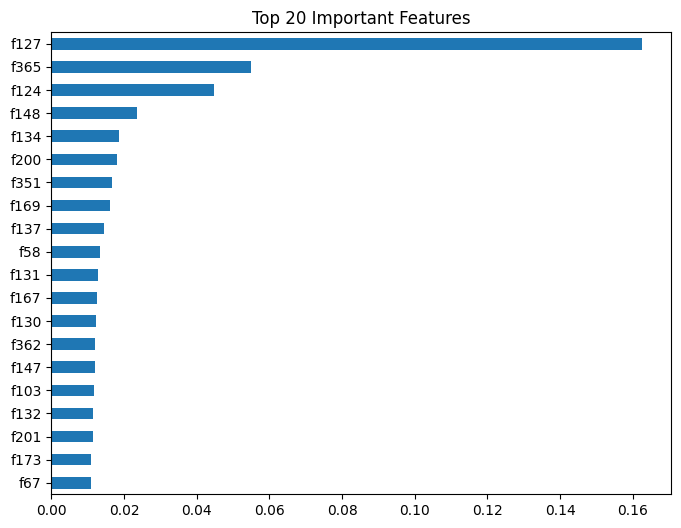

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the trained XGBoost model
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Optional: visualize
feature_importances.head(20).plot(kind='barh', figsize=(8,6), title="Top 20 Important Features")
plt.gca().invert_yaxis()
plt.show()


In [53]:
# Columns you want to retain no matter what
always_keep = [
    'offer_duration_days',
    'offer_event_count', 'unique_event_types', 'event_span_days',
    'Mobile_Timeline', 'OffersTab', 'Tiles',
    'global_avg_transaction', 'global_max_transaction', 'global_min_transaction'
]

# Drop those from the ranked list temporarily to avoid duplication
remaining_features = feature_importances.drop(labels=always_keep, errors='ignore')

# Select top 80 from remaining
top_80 = remaining_features.head(80).index.tolist()

# Combine
final_features = always_keep + top_80

# Subset train/val data
X_train_reduced = X_train[final_features]
X_val_reduced = X_val[final_features]


In [13]:
model_reduced = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    enable_categorical=True
)

model_reduced.fit(X_train_reduced, y_train)


C:\Users\astit\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:02:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [55]:
import joblib

# Save model
joblib.dump(model_reduced, 'model_reduced_xgb.pkl')


['model_reduced_xgb.pkl']

In [22]:
from sklearn.metrics import accuracy_score, classification_report

# Predict probabilities for the positive class
y_pred_proba = model_reduced.predict_proba(X_val_reduced)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_val, y_pred_proba)
print("ROC AUC Score:", roc_auc)


ROC AUC Score: 0.7723638477826895


In [27]:
# Get predicted probabilities for class 1 (click)
probs = model_reduced.predict_proba(X_val_reduced)[:, 1]

# Reattach customer_id and offer_id using saved X_ids (match the validation set indices)
ranking_df = X_ids.loc[X_val_reduced.index].copy()
ranking_df['click_proba'] = probs

# Rank offers by predicted probability per customer
ranking_df['rank'] = ranking_df.groupby('customer_id')['click_proba'].rank(ascending=False, method='first')

# Sort by customer_id and rank
ranking_df = ranking_df.sort_values(['customer_id', 'rank'])

# Optional: get top N offers per customer
top_n = 5
top_offers = ranking_df[ranking_df['rank'] <= top_n]

# Display result
display(top_offers.head(5))


,customer_id,offer_id,click_proba,rank
575716,1000043,93516,0.115358,1.0
17217,1000125,920925,0.296760,1.0
17232,1000125,27945,0.255532,2.0
17184,1000125,57342,0.244019,3.0
17176,1000125,93527,0.229858,4.0


MAP calculation

In [28]:
# Assuming you have original validation set with true click labels:
val_labels = y_val.loc[X_val.index]  # aligned to validation index

# Merge to get true labels in ranking_df
ranking_df = ranking_df.join(val_labels.rename('click'))


In [96]:
print("Count of y = 1:", (ranking_df['click'] == 1).sum())

Count of y = 1: 7410


In [51]:
def average_precision_at_k(actual, predicted, k=7):
    if not actual:
        return 0.0
    actual_set = set(actual)
    predicted = predicted[:k]
    score = 0.0
    hits = 0
    for i, p in enumerate(predicted):
        if p in actual_set:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(actual), k)

map_scores = []

for customer_id, group in ranking_df.groupby('customer_id'):
    # Sort by rank
    group = group.sort_values('rank')
    # Get predicted offer_ids (top-k)
    predicted = group['offer_id'].tolist()
    # Get actual clicked offers
    actual = group[group['click'] == 1]['offer_id'].tolist()
    
    ap = average_precision_at_k(actual, predicted, k=7)
    map_scores.append(ap)

# Final MAP@7
map7 = sum(map_scores) / len(map_scores)
print(f"MAP@7: {map7:.6f}")


MAP@7: 0.041087


Submission using TEST

In [54]:
# Step 1: Load test data (with all features)
test_df = pd.read_parquet("Datasets/test_data.parquet")  # or .csv

# Step 2: Prepare test data for model input (drop unnecessary cols if needed)

engineered_columns = [
    'offer_duration_days',
    'offer_event_count',
    'unique_event_types',
    'Mobile_Timeline',             # Renamed (from `mobile_timeline`)
    'OffersTab',                   # Renamed (from `offers_tab`)
    'Tiles',    
    'event_span_days',
    'global_avg_transaction',
    'global_max_transaction',
    'global_min_transaction'
]

# Remove engineered columns if present

print(final_features)
final_features = [col for col in final_features if col not in engineered_columns]

X_test = test_df[final_features]  # the same columns used during training




['offer_duration_days', 'offer_event_count', 'unique_event_types', 'event_span_days', 'Mobile_Timeline', 'OffersTab', 'Tiles', 'global_avg_transaction', 'global_max_transaction', 'global_min_transaction', 'f127', 'f365', 'f124', 'f148', 'f134', 'f200', 'f351', 'f169', 'f137', 'f58', 'f131', 'f167', 'f130', 'f362', 'f147', 'f103', 'f132', 'f201', 'f173', 'f67', 'f186', 'f76', 'f47', 'f203', 'f143', 'f123', 'f171', 'f202', 'f95', 'f98', 'f41', 'f142', 'f315', 'f166', 'f99', 'f204', 'f150', 'f149', 'f341', 'f96', 'f113', 'f43', 'f216', 'f223', 'f105', 'f168', 'f125', 'f158', 'f77', 'f46', 'f133', 'f69', 'f348', 'f68', 'f138', 'f199', 'f316', 'f146', 'f74', 'f30', 'f350', 'f172', 'f140', 'f51', 'f59', 'f322', 'f198', 'f320', 'f344', 'f93', 'f85', 'f170', 'f97', 'f151', 'f319', 'f318', 'f94', 'f106', 'f338', 'f336']


In [49]:
X_test = test_df[final_features].copy()  # ✅ avoid SettingWithCopyWarning

# Now convert object columns safely
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        try:
            X_test[col] = X_test[col].astype(float)
        except ValueError:
            X_test[col] = X_test[col].astype('category')


In [47]:
print(X_test.select_dtypes(include='object').columns)


Index([], dtype='object')


In [50]:
test_preds = model_reduced.predict_proba(X_test)[:, 1]


ValueError: feature_names mismatch: ['offer_duration_days', 'offer_event_count', 'unique_event_types', 'event_span_days', 'Mobile_Timeline', 'OffersTab', 'Tiles', 'global_avg_transaction', 'global_max_transaction', 'global_min_transaction', 'f127', 'f365', 'f124', 'f148', 'f134', 'f200', 'f351', 'f169', 'f137', 'f58', 'f131', 'f167', 'f130', 'f362', 'f147', 'f103', 'f132', 'f201', 'f173', 'f67', 'f186', 'f76', 'f47', 'f203', 'f143', 'f123', 'f171', 'f202', 'f95', 'f98', 'f41', 'f142', 'f315', 'f166', 'f99', 'f204', 'f150', 'f149', 'f341', 'f96', 'f113', 'f43', 'f216', 'f223', 'f105', 'f168', 'f125', 'f158', 'f77', 'f46', 'f133', 'f69', 'f348', 'f68', 'f138', 'f199', 'f316', 'f146', 'f74', 'f30', 'f350', 'f172', 'f140', 'f51', 'f59', 'f322', 'f198', 'f320', 'f344', 'f93', 'f85', 'f170', 'f97', 'f151', 'f319', 'f318', 'f94', 'f106', 'f338', 'f336'] ['f127', 'f365', 'f124', 'f148', 'f134', 'f200', 'f351', 'f169', 'f137', 'f58', 'f131', 'f167', 'f130', 'f362', 'f147', 'f103', 'f132', 'f201', 'f173', 'f67', 'f186', 'f76', 'f47', 'f203', 'f143', 'f123', 'f171', 'f202', 'f95', 'f98', 'f41', 'f142', 'f315', 'f166', 'f99', 'f204', 'f150', 'f149', 'f341', 'f96', 'f113', 'f43', 'f216', 'f223', 'f105', 'f168', 'f125', 'f158', 'f77', 'f46', 'f133', 'f69', 'f348', 'f68', 'f138', 'f199', 'f316', 'f146', 'f74', 'f30', 'f350', 'f172', 'f140', 'f51', 'f59', 'f322', 'f198', 'f320', 'f344', 'f93', 'f85', 'f170', 'f97', 'f151', 'f319', 'f318', 'f94', 'f106', 'f338', 'f336']
expected offer_event_count, global_avg_transaction, offer_duration_days, Mobile_Timeline, OffersTab, Tiles, global_min_transaction, event_span_days, unique_event_types, global_max_transaction in input data